## In this study, we propose discrete VAE. Generative model is as follows:


In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from vae_lib.utils.dynamic_gmm_on_circle import DynamicGmmOnCircle

In [2]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [3]:
def permute(X, y=None):
    n_all_cases = X.shape[0]
    perm = np.arange(n_all_cases)
    np.random.shuffle(perm)
    if y is not None:
        return X[perm], y[perm]
    else:
        return X[perm], None

In [4]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

In [8]:
def plot_2d_latent_space(model, onehot_encoder, X, y):
    m, sd = model_supervised.encode2(X_test)
    y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
    fig = plt.figure(figsize=(20, 20))


    plt.subplot(2, 2, 1)
    plt.scatter(m[:,0], m[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.scatter(sd[:,0], sd[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.scatter(m[:,0], sd[:,0], c=y_decoded, cmap='brg')
    plt.colorbar()

    Z = np.random.normal(m,sd)
    plt.subplot(2, 2, 4)
    plt.scatter(Z[:,0], Z[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.show()

In [ ]:
def plot_single_img(img, label):
    pixels = img.reshape((28, 28))

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

### Import MNIST

In [9]:
mnist = tf.keras.datasets.mnist

### Load data

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [11]:
X = np.concatenate((X_train, X_test), axis=0)

In [12]:
n_all_cases = X.shape[0]
input_dim = X.shape[1]

In [13]:
X = np.reshape(X, (n_all_cases, -1))
y = np.concatenate((y_train, y_test)).astype('float32')

In [14]:
label_reshaped = y.reshape(len(y), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [15]:
n_classes = onehot_encoded.shape[1]

In [16]:
X = (X > 0.5).astype(np.float32)

In [17]:
X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

### Utility functions

In [19]:
def get_log_folder():
    now = datetime.datetime.now()
    day_of_the_year=now.strftime("%d_%m_%Y")
    suff = now.strftime("%Y%m%d%H%M%S")
    #print(now.strftime("%Y%m%d%H%M%S"))
    log_folder = "/tmp/class_vae/deep/{}/{}".format(day_of_the_year,suff)
    return log_folder

In [20]:
def calculate_accuracy_np(y_pred, y_true):
    predicted_class = np.argmax(y_pred, axis=1)
    true_class = np.argmax(y_true, axis=1)
    cond_correct = predicted_class == true_class
    return np.mean(cond_correct.astype(int))

In [21]:
def accuracy_for_score(y_pred, y_true, score, threshold):
    cond = score > threshold
    accuracy = calculate_accuracy_np(y_pred[cond], y_true[cond])
    return accuracy

In [22]:
def classification_ratio(score, threshold):
    cond = score > threshold
    above_threshold = np.mean((score > threshold).astype(int))
    return above_threshold

### Build neural network

In [23]:
class DenseLayer:

    def __init__(self, in_dim, out_dim, f=tf.nn.relu, name="dense"):
        self.name = name
        with tf.name_scope(self.name):
            self.f = f
            initializer = tf.contrib.layers.xavier_initializer()
            self.W = tf.Variable(initializer((in_dim, out_dim)), name="W")
            self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
            tf.summary.histogram("weights", self.W)
            tf.summary.histogram("bias", self.b)

    def forward(self, X):
        with tf.name_scope(self.name):
            act = self.f(tf.matmul(X, self.W) + self.b)
            tf.summary.histogram("activation", act)
            return act

In [117]:
class VClassifier:
    
    def sample_gumbel(self, shape, eps=1e-20): 
        """Sample from Gumbel(0, 1)"""
        U = tf.random_uniform(shape,minval=0,maxval=1)
        return -tf.log(-tf.log(U + eps) + eps)

    def gumbel_softmax_sample(self, logits, temperature): 
        """ Draw a sample from the Gumbel-Softmax distribution"""
        y = logits + self.sample_gumbel(tf.shape(logits))
        return tf.nn.softmax( y / temperature)

    def gumbel_softmax(self, logits, temperature, hard=False):
        """Sample from the Gumbel-Softmax distribution and optionally discretize.
        Args:
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar
        hard: if True, take argmax, but differentiate w.r.t. soft sample y
        Returns:
        [batch_size, n_class] sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot, otherwise it will
        be a probabilitiy distribution that sums to 1 across classes
        """
        y = self.gumbel_softmax_sample(logits, temperature)
        if hard:
            k = tf.shape(logits)[-1]
            #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
            y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keep_dims=True)),y.dtype)
            y = tf.stop_gradient(y_hard - y) + y
        return y
    
    def encode(self, X, input_dim, hidden_dims):
        
        in_dim = input_dim
        for h_dim in hidden_dims[:-1]:
            h = DenseLayer(in_dim, h_dim)
            self.encoder_layers.append(h)
            in_dim = h_dim

        middle_layer_dim = hidden_dims[-1]
        self.encoder_layers.append(DenseLayer(in_dim, middle_layer_dim, f=lambda x: x))
        
        current_value = X
        for layer in self.encoder_layers:
            current_value = layer.forward(current_value)
            
        logits = current_value

        return logits
    
    def decode(self, Z, output_dim, hidden_dims):
        decoder_layers = []

        in_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
            h = DenseLayer(in_dim, hidden_dim)
            decoder_layers.append(h)
            in_dim = hidden_dim

        decoder_layers.append(DenseLayer(in_dim, output_dim, f=lambda x: x))

        current_value = Z
        for decoder_layer in decoder_layers:
            current_value = decoder_layer.forward(current_value)

        return current_value
    
    def calculateKL(self, mean, std):
        inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
        kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
        return tf.math.reduce_mean(kls)
    
    def calculateKLBernoulli(self, q_z, K):
        log_q_z = tf.log(q_z+1e-20)
        kl_tmp = q_z * log_q_z - tf.log(1.0/K)
        return tf.reduce_mean(tf.reduce_sum(kl_tmp, axis=1))
    
    def create_accuracy_node(self, y_true, y_pred):
        correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
        return accuracy_node
    
    def sample_eps(self, shape):
        return  tf.random_normal(shape=shape, mean=0, stddev=1, 
                               dtype=tf.float32)

    def __init__(self, x_dim, hidden_dims, log_folder):
        self.encoder_layers = []
        self.x_dim = x_dim
        self.layer = 1
        self.cum_thetas = []
        K = hidden_dims[-1]
        
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
        
        middle_logits = self.encode(self.X, x_dim, hidden_dims)
        
        q_z = tf.nn.softmax(middle_logits)
        self.Z = self.gumbel_softmax(middle_logits,0.5,True)
        
        #decoder
        self.logits = self.decode(self.Z, x_dim, hidden_dims)

        self.XY_hat_distribution = Bernoulli(logits=self.logits)

        self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)

        with tf.name_scope('COST'):

            expected_log_likelihood_2 = -tf.reduce_sum(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=self.logits), 
                axis=1
            )
            
            exp_loglik_2 = tf.reduce_mean(expected_log_likelihood_2)
            tf.summary.scalar("loglik_2", exp_loglik_2)
            
            KL = self.calculateKLBernoulli(q_z, K)
            tf.summary.scalar("KL", KL)
            
            elbo = exp_loglik_2 - KL
            tf.summary.scalar("elbo", elbo)
            
        
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(-elbo)

        self.init_op = tf.global_variables_initializer()
            
        #InteractiveSession.close()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

        self.merged_summary = tf.summary.merge_all()

        self.writer_train = tf.summary.FileWriter(log_folder)
        self.writer_train.add_graph(self.sess.graph)

    def fit(self, X_train, epochs=30, batch_sz=64):
        #costs=[]
        n_batches = len(X_train) // batch_sz
        print("n_batches:", n_batches)

        iteration = 1
        for i in range(epochs):
            print("epoch: %d" % i)
            #np.random.shuffle(X_train)
            X_train, _ = permute(X_train)
            for j in range(n_batches):
                batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
                self.sess.run(self.train_op, feed_dict={self.X: batch_x})
                if j % 100 == 0:
                    s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x})
                    self.writer_train.add_summary(s, iteration)

                iteration += 1

    def predict(self, x):
        z = self.sess.run(self.Z, feed_dict={self.X: x})
        print("z.shape={}".format(z.shape))
        y_pred = self.sess.run(self.posterior_predictive_probs, feed_dict={self.Z: z})
        return y_pred, z
    
#     def encode_image(self, x):
#         z = self.sess.run([self.Z], feed_dict={self.X: x})
#         return z


### Supervised VAE

In [118]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = VClassifier(
    x_dim=X_train.shape[1], 
    hidden_dims=[512, 10], 
    log_folder=log_folder
)
model_supervised.fit(X_train, epochs=10)


Starting autoencoder. Log folder=/tmp/class_vae/deep/16_04_2019/20190416182121
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/anaconda3/envs/vae_tests/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


In [120]:
x_img, latent_var = model_supervised.predict(X_train)
true_labels = np.argmax(y_train, axis=1)

z.shape=(63000, 10)


In [121]:
def plot_many_images(images, labels):

    ROW = 10
    COLUMN = 3
    for i in range(ROW * COLUMN):
        # train[i][0] is i-th image data with size 28x28
        image = images[i].reshape(28, 28)   # not necessary to reshape if ndim is set to 2
        plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
        plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
        # train[i][1] is i-th digit label
        plt.title('label = {}'.format(labels[i]))
        plt.axis('off')  # do not show axis value
    plt.tight_layout()   # automatic padding between subplots
    #plt.savefig('images/mnist_plot.png')
    plt.show()

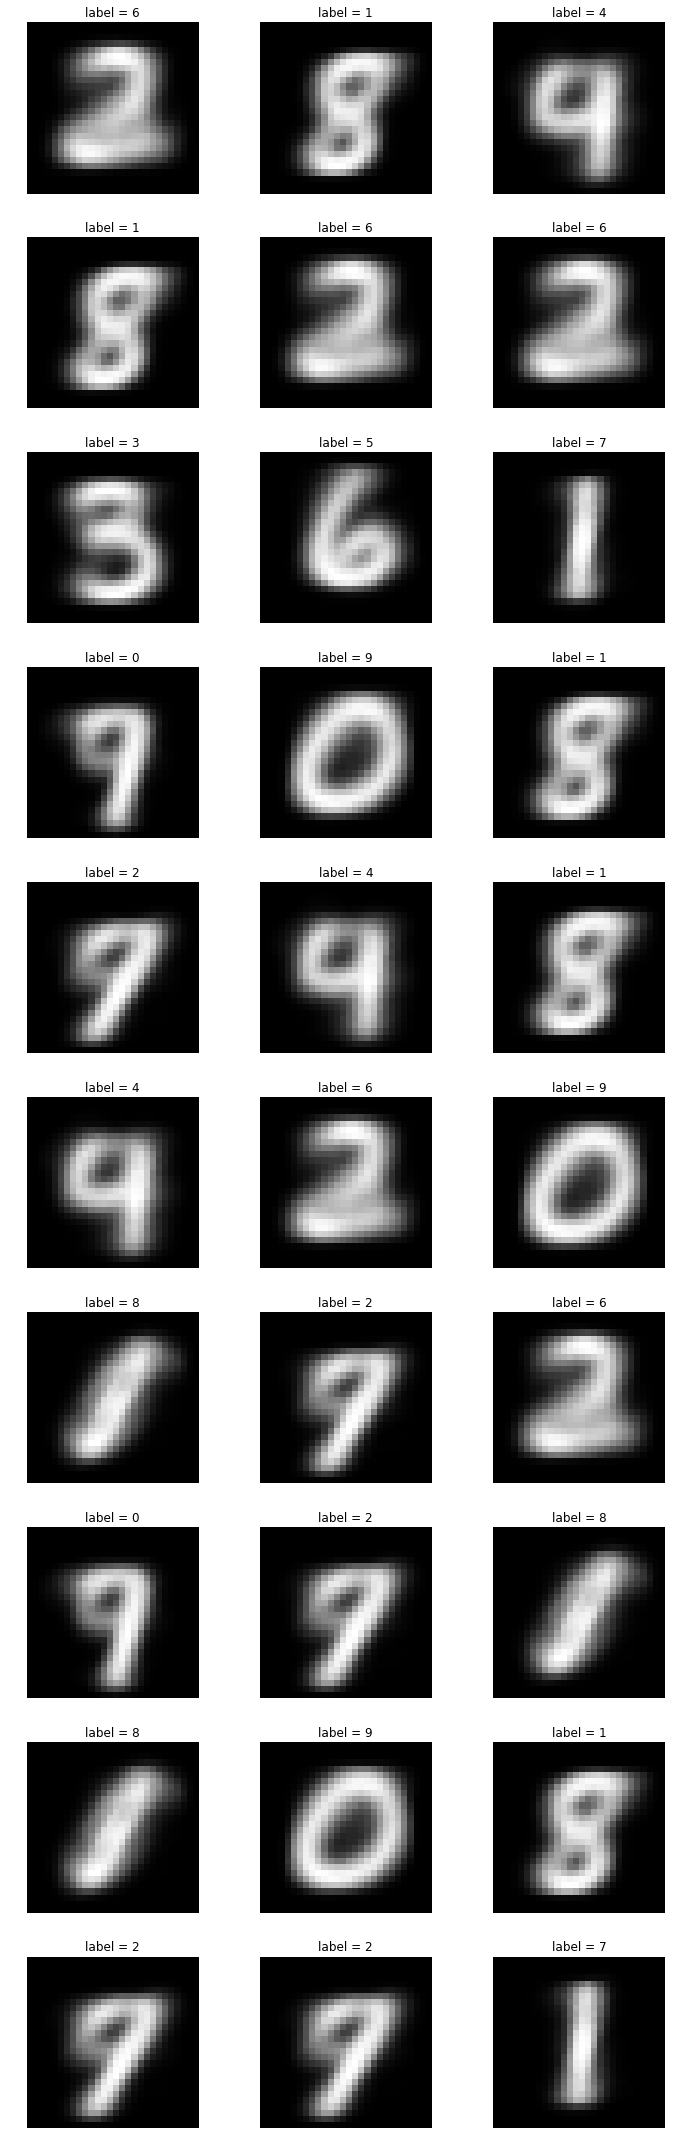

In [127]:
plt.figure(figsize=(10,30))
#x_img_bin = (x_img > 0.5).astype(np.float32)
#plot_many_images(x_img_bin, true_labels)
predicted_labels = np.argmax(latent_var, axis=1)
plot_many_images(x_img, predicted_labels)

In [107]:
# plt.figure(figsize=(20,20))
# plot_many_images(X_test, y_test)

In [116]:
latent_var

array([[1.05182535e-05, 2.58763338e-17, 2.48207515e-13, ...,
        1.75472655e-04, 1.10878820e-04, 9.99702632e-01],
       [2.37676591e-01, 6.85763268e-09, 2.94513831e-19, ...,
        6.11574352e-01, 1.35656720e-16, 2.15377863e-02],
       [8.13267422e-12, 1.32064906e-05, 4.63547332e-13, ...,
        5.01232356e-13, 1.29092079e-08, 7.44386844e-12],
       ...,
       [5.98712613e-05, 9.46849266e-10, 9.06842798e-02, ...,
        1.21862164e-14, 8.50530688e-11, 1.07274267e-09],
       [1.60240699e-04, 3.63532837e-12, 3.81880131e-18, ...,
        9.47788179e-01, 9.29455624e-10, 4.95847836e-02],
       [2.98173785e-01, 4.94428276e-09, 1.13426468e-15, ...,
        1.86276615e-01, 8.65128366e-15, 9.49949845e-06]], dtype=float32)

In [3]:
from vae_lib.utils.gmm_mixture_for_discrete_vae import GmmMixtureForDiscreteVae



In [4]:
gmm.generate_samples(betas=[0,1,0,0,0,0,0,0,0,0], n=10)

TypeError: list indices must be integers or slices, not Tensor